# Data selection and resource access

In this notebook you will:
- filter and collect resources based on properties in the metadata
- carry out simple analysis tasks on custom data collections such as counting files or words

In [30]:
# Make sure that the libraries we will need in this notebook are installed
!pip install lxml numpy matplotlib

# Define some handy defaults
nsmap = {"cmd": "http://www.clarin.eu/cmd/1",
         "cmdp_text": "http://www.clarin.eu/cmd/1/profiles/clarin.eu:cr1:p_1633000337997"}

from os.path import expanduser
data_dir = expanduser("~") + '/work/data'

# Retrieving metadata files

In [31]:
import requests
from io import BytesIO
from zipfile import ZipFile

'''
    This function gets and unpacks a metadata archive
'''
def unpack_metadata(set_id, target_dir):
    # construct the address of the .zip file with the metadata for one set
    md_zip_url = f'https://europeana-oai.clarin.eu/metadata/fulltext-aggregation/{set_id}.zip'
    
    # retrieve the .zip file
    print(f'Retrieving {md_zip_url}')
    resp = requests.get(md_zip_url)
    zipfile = ZipFile(BytesIO(resp.content))
    
    print(f'Extracting content in {target_dir}')
    zipfile.extractall(path=target_dir)
    print('Done')

In [32]:
'''
    We now call the function for the set of Polish newspapers and extract them in a temporary directory so that we can use it.
'''

import os
set_id = '9200357' # Poland
metadata_dir = f'{os.path.expanduser("~")}/work/temp/metadata/{set_id}'
unpack_metadata(set_id, metadata_dir)

Retrieving https://europeana-oai.clarin.eu/metadata/fulltext-aggregation/9200357.zip
Extracting content in /home/jovyan/work/temp/metadata/9200357
Done


# Data segmentation using metadata properties
Now we have the metadata available, we want to use the properties in the metadata to create useful data segments. For The metadata tells us, for instance, the year of publication of each newspaper. 

Thus, we can narrow down our selection of text files and at the same time, using the resource identifiers that are also found in the metadata, create a 'map' that allows us to look up specific files based on a property we are interested in, in this case year of publication.

In [33]:
from lxml import etree

'''
    This function returns the publication year and resource identifiers for a metadata record.
    If the record is not a text resource record, it returns nothing
'''
def get_year_and_ids(record_file):
    xml_tree = etree.parse(record_file)
    text_resource_root_node = xml_tree.xpath('//cmd:Components/cmdp_text:TextResource', namespaces=nsmap)

    if len(text_resource_root_node) < 1:
        # Metadata in file is not for a text resource...
        return None
    else:
        # Get the temporal coverage information
        year_text_node = xml_tree.xpath(
            '//cmdp_text:TextResource/cmdp_text:TemporalCoverage/cmdp_text:Start/cmdp_text:year/text()', namespaces=nsmap)
        if len(year_text_node) < 1:
            # No publication year found... this is unexpected!
            print(f'Warning: year information not found in {record_file}')
            return None
        else:
            year = year_text_node[0]
            # get the record identifiers
            record_ids_text_nodes = xml_tree.xpath(
                '//cmdp_text:SubresourceDescription/cmdp_text:IdentificationInfo/cmdp_text:identifier/text()', namespaces=nsmap)
            
            # we only want the numeric identifiers...
            record_numeric_ids = [id for id 
                                  in record_ids_text_nodes 
                                  if id.isnumeric()]
            
            # return the information found in the record as a tuple
            return(year, record_numeric_ids)    

In [34]:
'''
    Trying it out on a single file that we know to be there...
'''
sample_file = f'{metadata_dir}/Ilustrowany_Dziennik_Ludowy_1939.xml'
get_year_and_ids(sample_file)

('1939', ['3000095232409', '3000095232408', '3000095232410'])

In [35]:
'''
    Now we apply the function to all metadata files and construct an 'index'
    The index will be a dictionary that has the year as 'key' and a list of 
'''
index = {}
years_of_interest = range(1900, 1920)
for filename in os.listdir(metadata_dir):
    if filename.endswith('.xml'):
        info = get_year_and_ids(f'{metadata_dir}/{filename}')
        # did we in fact get metadata for a text resource?
        if info:
            # break down the info
            (year, ids) = info
            if int(year) in years_of_interest: # int(year) gives us a numeric value needed to check against range
                # add to our index
                if not year in index: # does the index have an entry for the year?
                    # if not, make the entry
                    index[year] = []
                # append the identifiers to the entry
                index[year] += ids

# summarize our index: (year, id count)
[(year, len(index[year]))for year in sorted(index)]

[('1900', 50),
 ('1901', 52),
 ('1902', 53),
 ('1903', 51),
 ('1904', 52),
 ('1906', 52),
 ('1907', 51),
 ('1908', 51),
 ('1910', 39),
 ('1911', 53),
 ('1912', 53),
 ('1913', 51),
 ('1914', 1410),
 ('1915', 1939),
 ('1916', 1764),
 ('1917', 1616),
 ('1918', 2092),
 ('1919', 1713)]

# Accessing the resources for simple data analysis

In [36]:
'''
    We will now use the identifiers to access the resource files
'''
def get_resource_file(identifier):
    # Some knowledge we need to have and encode here about the relation between an 
    # identifier and the exact name of the file that contains the text
    return f'{data_dir}/{set_id}/BibliographicResource_{identifier}.txt'

# Try it out on the first identifier for a specific year in our index
get_resource_file(index['1900'][0])

'/home/jovyan/work/data/9200357/BibliographicResource_3000095240561.txt'

In [37]:
'''

    A function that carries out a very simple analysis on a file: count the words
    Here we define word as any white-space separated group of one or more characters
'''
def count_words(filename):
    if os.path.exists(filename):
        # open the file
        with open(filename, 'r') as file:
            # gather the number of words per line
            words_per_line = [len(str.split(line)) # splitting the text of the line and counting the items does the job for us!
                              for line
                              in file.readlines()]
            # return the sum
            return sum(words_per_line)

# Try it out on a random file
test_filename = get_resource_file(index['1900'][0])
count_words(test_filename)

13219

In [38]:
'''
    Now let's do this on all files in our index, and store the results per year.
    
    Note: this can take a while!
'''

# We use the 'NumPy' library because this makes it much easier to work with numeric data arrays
import numpy as np

counts_index = {}
for year in sorted(index.keys()):
    counts = [count_words(get_resource_file(identifier)) 
                          for identifier 
                          in index[year]]
    
    # Wrap the counts in a NumPy array
    np_counts = np.array(counts)

    # Finally, exclude 'None' and '0' counts (which happen if the resource is not available)
    # and store the result in the index
    counts_index[year] = np_counts[np_counts.nonzero()]

print('Done')

Done


## Simple statistics on our data

In [39]:
'''
    Now we can get some statistics out of our index counts!
'''
print('Total words for each year:')
print([(year, counts_index[year].sum()) for year in counts_index])

print('')

print('Maximum number of words per issue for each year:')
print([(year, counts_index[year].max()) for year in counts_index])

print('')

print('Average words per issue for each year:')
print([(year, round(counts_index[year].mean())) for year in counts_index])


Total words for each year:
[('1900', 580164), ('1901', 570691), ('1902', 548502), ('1903', 576782), ('1904', 599954), ('1906', 674893), ('1907', 559004), ('1908', 503666), ('1910', 435152), ('1911', 524921), ('1912', 546615), ('1913', 446685), ('1914', 6637197), ('1915', 6692755), ('1916', 9353881), ('1917', 8134574), ('1918', 9837312), ('1919', 6251652)]

Maximum number of words per issue for each year:
[('1900', 18513), ('1901', 18486), ('1902', 14054), ('1903', 19107), ('1904', 15791), ('1906', 20640), ('1907', 15745), ('1908', 12627), ('1910', 27868), ('1911', 15395), ('1912', 14350), ('1913', 13368), ('1914', 22847), ('1915', 22435), ('1916', 31131), ('1917', 29691), ('1918', 29090), ('1919', 23935)]

Average words per issue for each year:
[('1900', 13492), ('1901', 12406), ('1902', 12466), ('1903', 13414), ('1904', 13332), ('1906', 13498), ('1907', 11646), ('1908', 10949), ('1910', 13598), ('1911', 11930), ('1912', 11630), ('1913', 9504), ('1914', 8380), ('1915', 7773), ('1916', 

## Data visualization example

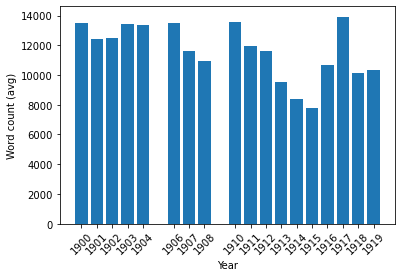

In [40]:
'''
    We're using Pyplot to plot a chart of the average issue word count per year in our data set
'''

import matplotlib.pyplot as plt

years = [int(year) for year in counts_index]
averages = [round(counts_index[year].mean()) for year in counts_index]

# create a figure
fig, ax = plt.subplots()

# position data on axes
ax.bar(years, averages)

# set labels and tweak label rendering on axes
plt.xlabel('Year')
plt.ylabel('Word count (avg)')
plt.xticks(years, counts_index.keys(), rotation=45)

# show the plot
plt.show()